In [24]:
import os
from config import config

CODA_DLL_PATH = config["preprocessing"]["coda_dll_path"]
H5_FILE = config["main"]["h5_file"]
CLASSES = config.get_classes()
IMG_SIZE = int(config["main"]["img_size"])

os.add_dll_directory(
    CODA_DLL_PATH
)  # https://github.com/tensorflow/tensorflow/issues/48868#issuecomment-841396124



import preprocessing
from plogging import logger

dataset = preprocessing.create_dataset(H5_FILE, rotation=True)
logger.info(CLASSES)
logger.info(dataset.head())

[20:18:50] Create dataset started [h5_file=SynthText.h5]
[20:24:47] Function 'create_dataset' executed in 356.6857s
[20:24:47] ['Ubuntu Mono', 'Alex Brush', 'Raleway', 'Roboto', 'Russo One', 'Open Sans', 'Michroma']
[20:24:47]                                                  img       font char  word  \
0  [[71, 71, 71, 71, 74, 91, 105, 116, 122, 122, ...  Open Sans    o   on,   
1  [[73, 73, 73, 75, 82, 100, 92, 87, 76, 69, 87,...  Open Sans    n   on,   
2  [[72, 71, 68, 65, 64, 64, 65, 68, 71, 78, 86, ...  Open Sans    ,   on,   
3  [[129, 129, 129, 129, 129, 129, 129, 129, 129,...    Raleway    l  load   
4  [[135, 135, 135, 135, 135, 135, 135, 135, 135,...    Raleway    o  load   

             img_name  
0  ant+hill_102.jpg_0  
1  ant+hill_102.jpg_0  
2  ant+hill_102.jpg_0  
3  ant+hill_102.jpg_0  
4  ant+hill_102.jpg_0  


In [25]:
logger.info(dataset["font"].value_counts())

[20:24:47] Ubuntu Mono    5009
Alex Brush     4363
Raleway        4301
Roboto         4264
Russo One      3994
Open Sans      3637
Michroma       2629
Name: font, dtype: int64


In [26]:
# add additional images
import generate
import numpy as np

images = generate.generate_images(num_images=20)

dataset = np.concat([dataset, images])
dataset = dataset.sample(frac=1).reset_index(drop=True) # shuffle
logger.info("After generation:")
logger.info(dataset["font"].value_counts())

In [ ]:
import numpy as np
import tensorflow as tf

X = dataset.drop(columns=["font"])
Y = np.array(dataset["font"].apply(lambda s : CLASSES.index(s)))

CAT_CLASSES = tf.keras.utils.to_categorical(np.unique(Y))

f_ = lambda i : CAT_CLASSES[i]

Y = f_(Y)


In [ ]:
import metrics

def log_stats(y_test, y_pred):
    recall = tf.keras.metrics.Recall()
    recall.update_state(y_test, y_pred)
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_test, y_pred)
    auc = tf.keras.metrics.AUC()
    auc.update_state(y_test, y_pred)
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(y_test, y_pred)

    print(f"Accuracy: {acc.result().numpy()}")
    print(f"Recall: {recall.result().numpy()}")
    print(f"Precision: {precision.result().numpy()}")
    print(f"AUC: {auc.result().numpy()}")

def eval_model(history,x_test, y_test, y_pred, classes, save=True):
    logger.info("Model stats:")
    metrics.plot_acc(history, save=save)
    metrics.plot_loss(history, save=save)
    
    
    log_stats(y_test, y_pred)
    metrics.plot_roc(y_test, y_pred, CLASSES, zoom=False, save=save)
    metrics.plot_confusion_matrix(y_test, y_pred, classes, save=save)





In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.2)
metrics_ = ['accuracy', tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()] #interesting metrics

x_train_norm = np.array(x_train["img"].to_list())/255 # normalize
x_test_norm = np.array(x_test["img"].to_list())/255 # normalize

logger.info(f"Train samples size [x_train={len(x_train)}, x_test={len(x_test)}]")

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]

model = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    tf.keras.layers.LayerNormalization(axis=1 , center=True , scale=True),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', metrics=metrics_, loss='categorical_crossentropy')
model.summary()
history = model.fit(x_train_norm, y_train, epochs=20, validation_data=(x_test_norm, y_test), verbose=1, callbacks=callbacks)
y_pred = model.predict(x_test_norm)


[19:36:41] Train samples size [x_train=22557, x_test=5640]
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 layer_normalization_4 (Laye  (None, 30, 30, 32)       60        
 rNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                         

[19:45:31] Model stats:


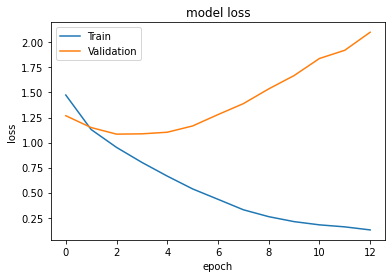

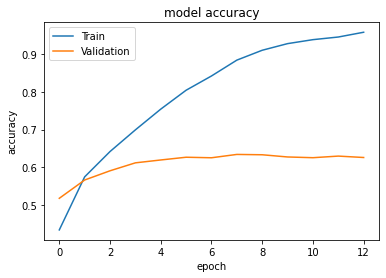

Accuracy: 0.6260638236999512
Recall: 0.6166666746139526
Precision: 0.6462281942367554
AUC: 0.8733553886413574


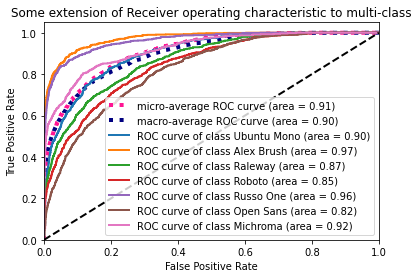

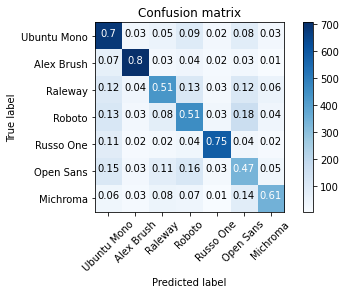

In [ ]:
eval_model(history,x_test,y_test, y_pred, CLASSES, save=True)

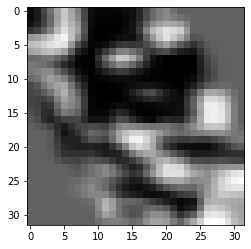

[19:23:41] Char: e
[19:23:41] Image: war_2.jpg_0
[19:23:41] Predicted label: Ubuntu Mono
[19:23:41] True label: Roboto


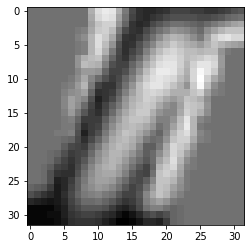

[19:23:41] Char: ,
[19:23:41] Image: bedroom_12.jpg_0
[19:23:41] Predicted label: Ubuntu Mono
[19:23:41] True label: Open Sans


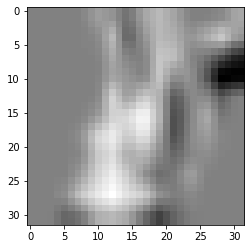

[19:23:41] Char: .
[19:23:41] Image: zoo_99.jpg_0
[19:23:41] Predicted label: Russo One
[19:23:41] True label: Open Sans


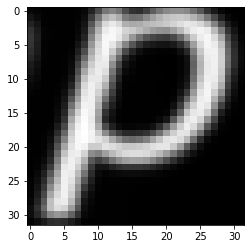

[19:23:41] Char: p
[19:23:41] Image: net_7.jpg_0
[19:23:41] Predicted label: Ubuntu Mono
[19:23:41] True label: Roboto


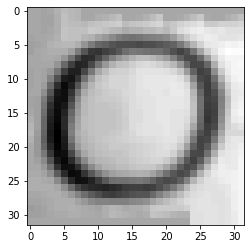

[19:23:42] Char: O
[19:23:42] Image: kathak_53.jpg_0
[19:23:42] Predicted label: Raleway
[19:23:42] True label: Open Sans


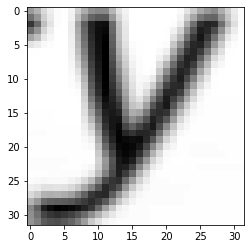

[19:23:42] Char: y
[19:23:42] Image: photos_112.jpg_0
[19:23:42] Predicted label: Open Sans
[19:23:42] True label: Ubuntu Mono


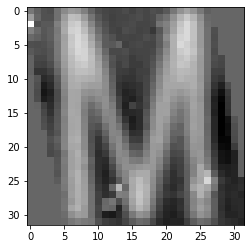

[19:23:42] Char: M
[19:23:42] Image: swimming_77.jpg_0
[19:23:42] Predicted label: Open Sans
[19:23:42] True label: Roboto


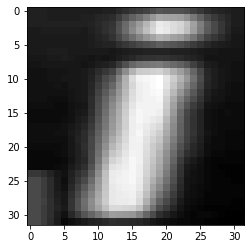

[19:23:42] Char: i
[19:23:42] Image: sun_16.jpg_0
[19:23:42] Predicted label: Roboto
[19:23:42] True label: Michroma


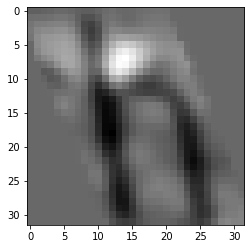

[19:23:42] Char: h
[19:23:42] Image: zoo_106.jpg_0
[19:23:42] Predicted label: Ubuntu Mono
[19:23:42] True label: Roboto


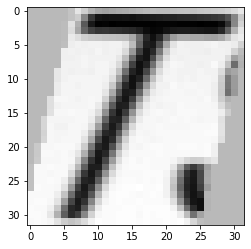

[19:23:42] Char: T
[19:23:42] Image: ballet_99.jpg_0
[19:23:42] Predicted label: Raleway
[19:23:42] True label: Roboto


In [ ]:
# plots a sample of model errors
import matplotlib.pyplot as plt

predict = np.argmax(y_pred, axis=1)
true_y_val = np.argmax(y_test, axis=1)
errors = np.flatnonzero(predict != true_y_val)

for i in np.random.choice(errors, 10):
    x_ = x_test.iloc[i, :]
    plt.imshow(x_["img"], cmap="gray")
    plt.show()
    logger.info("Char: {}".format(x_["char"]))
    logger.info("Image: {}".format(x_["img_name"]))
    logger.info("Predicted label: {}".format(CLASSES[predict[i]]))
    logger.info("True label: {}".format(CLASSES[true_y_val[i]]))